In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
np.warnings.filterwarnings('ignore')

In [3]:
X_test = pd.read_csv('X_test_tree.csv')
X_train = pd.read_csv('X_train_tree.csv')
y_test = pd.read_csv('y_test_tree.csv')
y_train = pd.read_csv('y_train_tree.csv')

In [4]:
X_train = X_train.set_index('Unnamed: 0')
y_train = y_train.set_index('Unnamed: 0')
X_test = X_test.set_index('Unnamed: 0')
y_test = y_test.set_index('Unnamed: 0')

# BASELINE

In [ ]:
baseline = GradientBoostingClassifier(random_state=1).fit(X_train, y_train)

Accuracy:  84.95439136057037
ROC-AUC:  0.8596169539925634
Precision:  0.6049158693500495
Recall:  0.37107872900222627


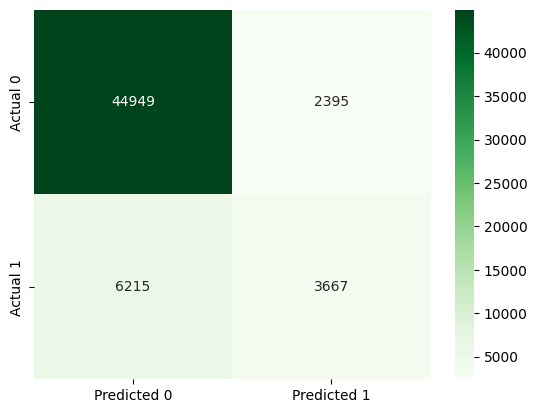

In [ ]:
y_pred_prob = baseline.predict_proba(X_train)[:,1] 

y_pred = y_pred_prob > 0.5
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_train)*100)
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Accuracy:  84.58796393373873
ROC-AUC:  0.8489613364122486
Precision:  0.6079088471849866
Recall:  0.3589236248516027


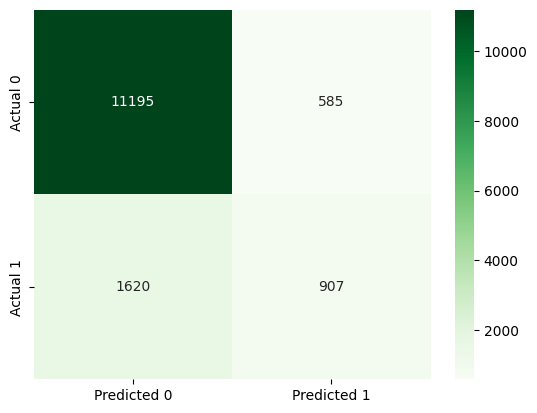

In [ ]:
y_pred_prob = baseline.predict_proba(X_test)[:,1] 
y_pred = y_pred_prob > 0.5
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

# FIRST TUNE

In [ ]:
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,2,3,4,5]
grid['subsample'] = [0.5,1.0]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
opt_params = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, n_iter = 10, cv=cv, verbose = True, scoring = 'recall')
results = opt_params.fit(X_train, y_train)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.392936 using {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01}


In [ ]:
y_train = np.ravel(y_train)

In [ ]:
model = results.best_estimator_
cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)
  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

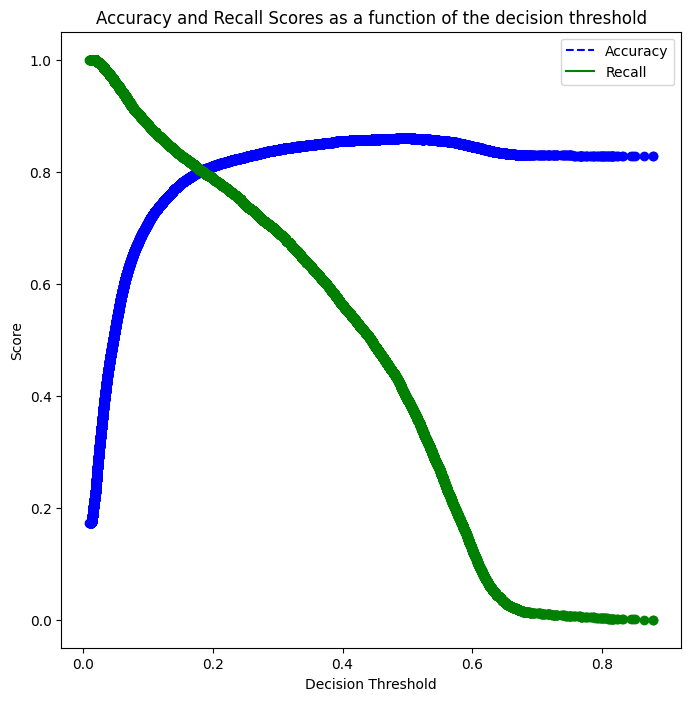

In [ ]:
model.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

y_pred_prob = model.predict_proba(X_train)[:,1]

for t in thresholds:
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [ ]:
metrics.loc[(metrics.accuracy>=80), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.191000
accuracy     80.007339
recall       79.427241
Name: 191, dtype: float64

Accuracy:  80.59448502428967
ROC-AUC:  0.8759986685829593
Precision:  0.46449102839556355
Recall:  0.809451528030763


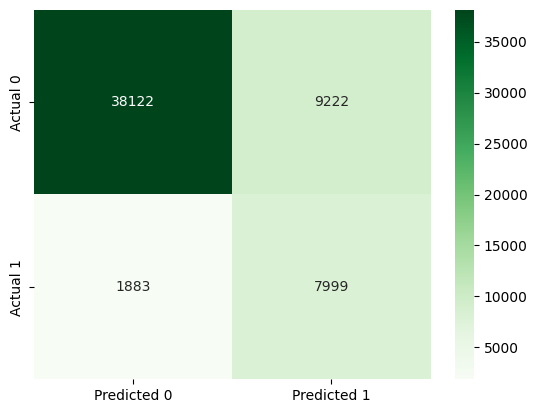

In [ ]:
y_pred_prob = model.predict_proba(X_train)[:,1] 

y_pred = y_pred_prob > 0.191
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_train)*100)
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Accuracy:  80.24743132732229
ROC-AUC:  0.8602178643821599
Precision:  0.4648483423465789
Recall:  0.7823506133755441


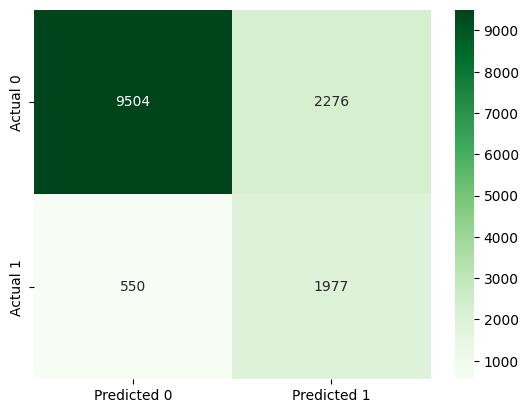

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1] 
y_pred = y_pred_prob > 0.191
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

# SECOND TUNING

Best: 0.571678 using {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 1.0}

In [ ]:
model2 = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [500, 550]
grid['learning_rate'] = [0.9, 1.0, 1.1]
grid['max_depth'] = [3,4]
grid['subsample'] = [1.0]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
opt_params = GridSearchCV(estimator=model2, param_grid=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'recall')
results = opt_params.fit(X_train, y_train) 
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best: 0.653373 using {'learning_rate': 0.9, 'max_depth': 4, 'n_estimators': 550, 'subsample': 1.0}


In [ ]:
model2 = results.best_estimator_
cross_val_ypred = cross_val_predict(model2, X_train, y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)
  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

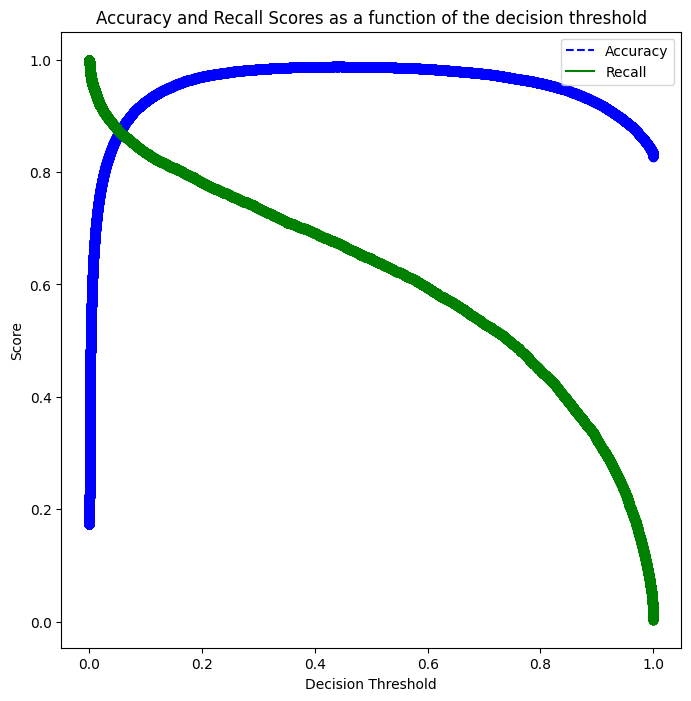

In [ ]:
model2.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

y_pred_prob = model2.predict_proba(X_train)[:,1]

for t in thresholds:
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [ ]:
metrics.loc[(metrics.accuracy>=84), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.090000
accuracy     84.012512
recall       84.153005
Name: 90, dtype: float64

Accuracy:  94.66850732184672
ROC-AUC:  0.9975223799160613
Precision:  0.7682821459429738
Recall:  0.989779396883222


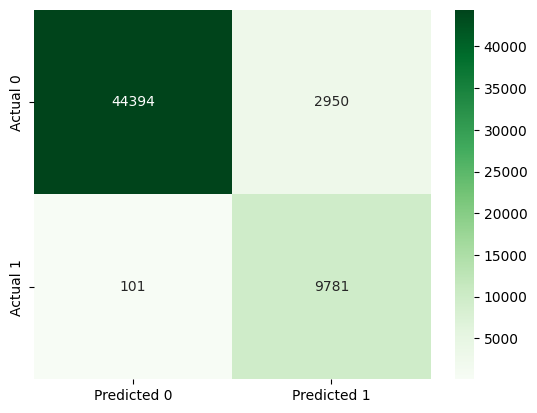

In [ ]:
y_pred_prob = model2.predict_proba(X_train)[:,1] 

y_pred = y_pred_prob > 0.134
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_train)*100)
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Accuracy:  87.41175648284056
ROC-AUC:  0.925867490189149
Precision:  0.6010579064587973
Recall:  0.854372774040364


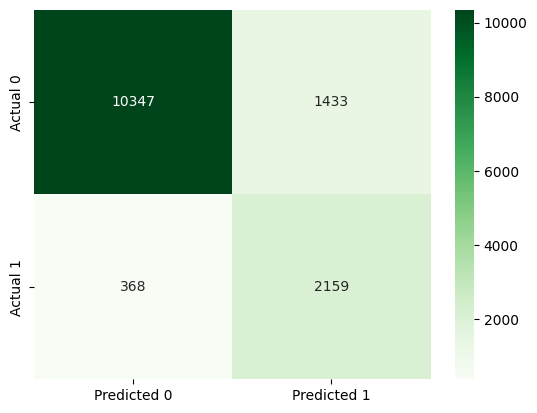

In [ ]:
y_pred_prob = model2.predict_proba(X_test)[:,1] 
y_pred = y_pred_prob > 0.134
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

# FINAL MODEL

In [5]:
boosting_model = GradientBoostingClassifier(random_state = 1, subsample=1.0, n_estimators=550, max_depth=4, learning_rate=0.9).fit(X_train, y_train)

Accuracy:  85.02131823582862
ROC-AUC:  0.925867490189149
Precision:  0.547713717693837
Recall:  0.8721804511278195


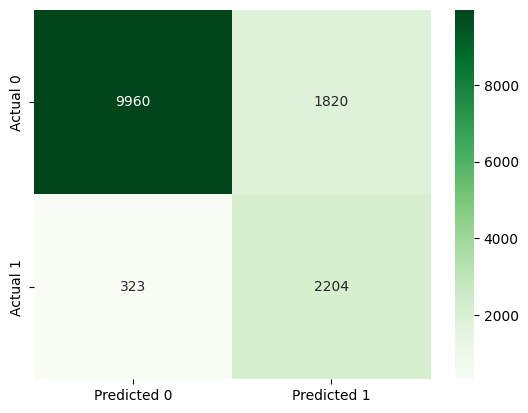

In [6]:
y_pred_prob = boosting_model.predict_proba(X_test)[:,1] 
y_pred = y_pred_prob > 0.09
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

In [10]:
importances = boosting_model.feature_importances_
importances = pd.DataFrame(importances)
df = pd.concat([pd.DataFrame(boosting_model.feature_names_in_, columns = ['Predictors']), importances], axis = 1)
df = df.rename(columns = {0: 'Importances'})
df.set_index('Predictors').sort_values(by = 'Importances', ascending = False)
df

,Predictors,Importances
0,HETENURE,0.018551
1,HEFAMINC,0.300670
2,HWHHWGT,0.125716
3,HRNUMHOU,0.095397
4,HRHTYPE,0.017858
5,HRMIS,0.012932
6,HRHHID2,0.013043
7,GEDIV,0.011284
8,GESTFIPS,0.022956
9,GTCBSA,0.025123
